In [ ]:
import numpy as np
from matplotlib import pyplot
from osgeo import gdal
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import geopandas as gpd
import rasterio as rio
import shutil, os
import shapely
import csv
import os
from rasterio.plot import show
from rasterio.warp import calculate_default_transform, reproject, Resampling

sns.set(font_scale=1.35, style='whitegrid')
%config Completer.use_jedi = False

In [ ]:
''' This script illustrates the data processing done on Colorado ASO snapshots '''

' This script illustrates the data processing done on Colorado ASO snapshots '

In [ ]:
def reproject_raster(src_file, dst_file, dst_crs = 'EPSG:4269'):
    """Reproject the src_file to a coordinate system specified by dst_crs.
    The result in stored in dst_file. EPSG:4269 corresponds to the coordinate
    system employed by PRISM.
    Source: https://rasterio.readthedocs.io/en/latest/topics/reproject.html"""

    """calculate_default_transform(): transforms bounds to target coordinate system, calculates resolution if
    not provided, and returns destination transform and dimensions."""

    with rio.open(src_file) as src:
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds)
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': dst_crs,
            'transform': transform,
            'width': width,
            'height': height
        })

        with rio.open(dst_file, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rio.band(src, i),
                    destination=rio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest)
    return

Aggregatation Functions:

To faciliate comparison between ASO and PRISM, the ASO data need to be upscaled from 50-meter to 200-meter, 400-meter and 800-meter.

The following functions help achieve this.

In [ ]:
def aggregate2x2(src_array):
    """This function upscales src_array by a factor of 2. Specifically, it uses a 2x2 kernel
    (with a stride of 2) and average pools the src_array.
    """
    src_array = make_shape_even(src_array)
    agg_list = [[np.mean(src_array[row:row+2, col:col+2]) for col in np.arange(0,src_array.shape[1],2)] for row in np.arange(0,src_array.shape[0],2)]
    agg_array = np.array(agg_list).reshape(src_array.shape[0]//2,src_array.shape[1]//2) #deviding the size
    return np.asarray(agg_array, dtype=src_array.dtype)


def make_shape_even(src_array):
    """This function ensures that the shape of a masked array is divisible 2.
    If not divisible by 2, this functions pads the borders with nan."""
    rows = src_array.shape[0]
    cols = src_array.shape[1]
    rows_dest = rows+1 if rows%2==1 else rows
    cols_dest = cols+1 if cols%2==1 else cols
    dst_array = np.empty((rows_dest,cols_dest))
    dst_array[:] = np.nan
    dst_array[:rows,:cols] = src_array.copy()
    return np.asarray(dst_array, dtype=src_array.dtype)

write_agg_geotif function to save aggregated array
After aggregating, copy the meta information from the source file, and update the transform.

In [ ]:
def write_agg_geotif(template, agg_array, dst_filename):
    """Write the aggregated dataset. This assumes that the
    aggregated dataset upscales src by a factor of 2. For other
    factors, replace '2' by the actual factor."""

    transform = template.transform * template.transform.scale(2,2)
    width = int(np.ceil(template.width/2))
    height = int(np.ceil(template.height/2))
    kwargs = template.meta.copy()
    kwargs.update({
        'transform': transform,
        'width': width,
        'height': height
    })


    with rio.open(dst_filename, "w", **kwargs) as dest:
        dest.write(agg_array,1)
        dest.nodata = template.read(1, masked=True).fill_value

    return

After Aggregating ASO data to 800m resolution, ASO data and PRISM data still exhibit slightly different pixel sizes. Rescale to ensure that the PRSIM and ASO data have the same pixel size at 800m resolution.

In [ ]:
def rescale_src_from_template(template_file, src_file, dst_file):
    """This function rescales the src_file raster to the resolution of the template_file raster.
    The rescaled src_file is stored in dst_file raster."""
    template = rio.open(template_file)
    src = rio.open(src_file)

    scale_factor = template.res[0]/src.res[0]

    src_transform = src.transform

    dst_transform = src.transform * src.transform.scale(scale_factor,scale_factor)
    height = int(src.meta['height']/scale_factor)
    width = int(src.meta['width']/scale_factor)

    data = src.read()

    kwargs = src.meta.copy()
    kwargs['transform'] = dst_transform
    kwargs['height'] = height
    kwargs['width'] = width
    kwargs['crs'] = template.crs
    src.close()


    with rio.open(dst_file, 'w', **kwargs) as dst:

        for i, band in enumerate(data, 1):
            dest = np.zeros((height, width), dtype=band.dtype)

            reproject(
                band,
                dest,
                src_transform=src_transform,
                src_crs=template.crs,
                src_nodata=-9999,
                dst_transform=dst_transform,
                dst_crs=template.crs,
                resampling=Resampling.bilinear)

            dst.write(dest, indexes=i)
    return

translate_rescaled_src Function to align PRISM and ASO grids

A careful visual inspection reveals that although the PRISM and ASO pixel sizes are now identical, the grids are still not aligned.

In [ ]:
def get_Points_gdf(src_file):
    """This function reads in a raster, and obtains Long/Lat values of the center
    of each pixel. It returns a geodataframe."""
    raster = rio.open(src_file)
    arr = raster.read(1)
    indices = np.argwhere(~np.isnan(arr))

    coords = raster.xy(indices[:,0], indices[:,1])

    Points_gdf= gpd.GeoDataFrame({'Longitude':coords[0],'Latitude': coords[1]},
                                  geometry=[shapely.geometry.Point(x, y) for x, y in zip(coords[0], coords[1])])
    return Points_gdf



def translate_rescaled_src(template_file, src_file, rescaled_src_file, Points_gdf, dst_file):
    """This function rescales and translates the src_file raster so that the grid is perfectly
    aligned with the template_file raster grid. It uses the rescaled_src_file to determine how much
    translation is needed."""

    template = rio.open(template_file)
    rescaled_src = rio.open(rescaled_src_file)

    rc = rio.transform.rowcol(rescaled_src.transform, Points_gdf.Longitude[0], Points_gdf.Latitude[0])
    cr_coord = [item + 0.5 for item in reversed(rc)]

    pixel_coord = ~rescaled_src.transform*(Points_gdf.Longitude[0], Points_gdf.Latitude[0])
    pixel_coord = list(pixel_coord)

    offset_x = pixel_coord[0] - cr_coord[0]
    offset_y = pixel_coord[1] - cr_coord[1]



    with rio.open(src_file) as src:

        scale_factor = template.res[0]/src.res[0]

        src_transform = src.transform

        dst_transform = src.transform * src.transform.scale(scale_factor,scale_factor) * src.transform.translation(offset_x,offset_y)

        height = int(src.meta['height']/scale_factor)
        width = int(src.meta['width']/scale_factor)

        data = src.read()

        kwargs = src.meta.copy()
        kwargs['transform'] = dst_transform
        kwargs['height'] = height
        kwargs['width'] = width
        kwargs['crs'] = template.crs



        with rio.open(dst_file, 'w', **kwargs) as dst:

            for i, band in enumerate(data, 1):
                dest = np.zeros((height, width), dtype=band.dtype)

                reproject(
                    band,
                    dest,
                    src_transform=src_transform,
                    src_crs=template.crs,
                    src_nodata=-9999,
                    dst_transform=dst_transform,
                    dst_crs=template.crs,
                    resampling=Resampling.bilinear)

                dst.write(dest, indexes=i)

    return

This code is to reproject and aggregate all ASO files creating 5 Reprojected files at resolution 50M, 100M, 200M, 400M, 800M

In [ ]:
ASO_files = ['ASO_800M_SWE_USCOBR_20190419.tif', 'ASO_800M_SWE_USCOBR_20190624.tif', 'ASO_800M_SWE_USCOCB_20160404.tif',
            'ASO_800M_SWE_USCOCM_20190407.tif', 'ASO_800M_SWE_USCOCM_20190610.tif', 'ASO_800M_SWE_USCOGE_20180331.tif',
            'ASO_800M_SWE_USCOGE_20180524.tif', 'ASO_800M_SWE_USCOGE_20190407.tif', 'ASO_800M_SWE_USCOGE_20190610.tif',
            'ASO_800M_SWE_USCOGT_20180330.tif','ASO_800M_SWE_USCOGT_20190408.tif', 'ASO_800M_SWE_USCOGT_20190609.tif']

PRISM_file_800M = 'PRISM_TMEAN_20190323.tif'

for ASO_file in ASO_files:

    # reproject ASO file
    ASO_file_reprojected = 'Reprojected' + ASO_file
    desired_crs = 'EPSG:4269'
    reproject_raster(ASO_file, ASO_file_reprojected, desired_crs)

    #Rescaling the ASO_file according to the PRISM_file_800M and saving it in the rescaled_ASO_file
    template_file = PRISM_file_800M
    rescaled_ASO_file = 'Rescaled_' + ASO_file_reprojected
    rescale_src_from_template(PRISM_file_800M, ASO_file_reprojected, rescaled_ASO_file)


    #we are aligning rescaled_ASO_file according to the prism file
    Points_gdf = get_Points_gdf(template_file)
    rescaled_translated_ASO_file = 'Translated_' + rescaled_ASO_file
    translate_rescaled_src(template_file, ASO_file_reprojected, rescaled_ASO_file, Points_gdf, rescaled_translated_ASO_file)


Rescaling depends on resolution, for that reason I segregated ASO files in terms of resolution.

## Visualize the translated, rescaled, and reprojected ASO files

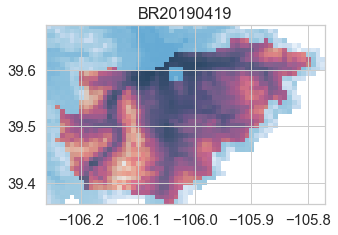

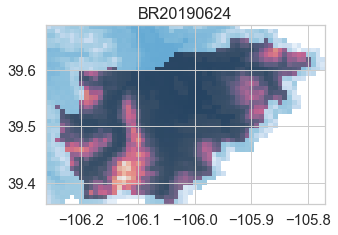

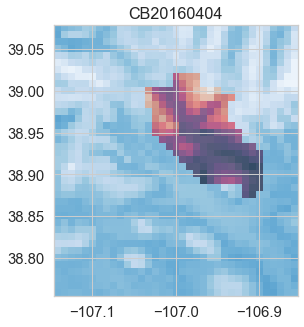

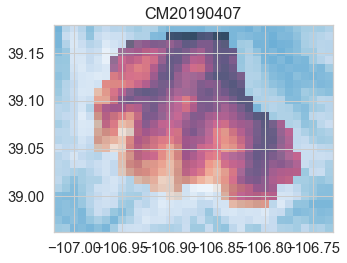

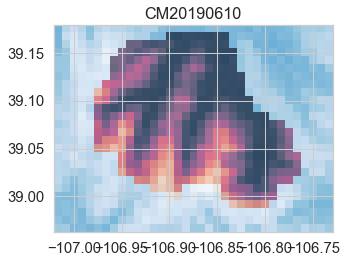

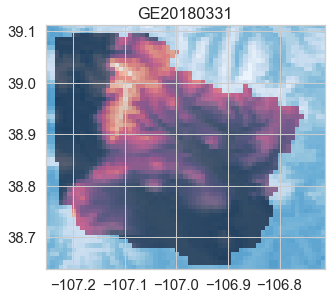

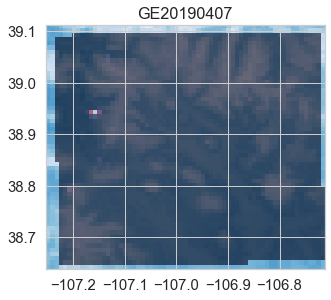

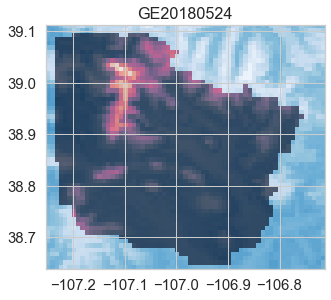

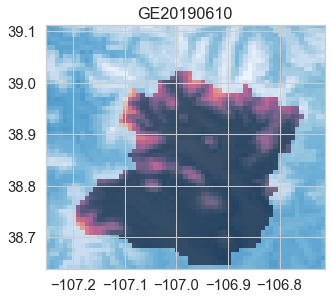

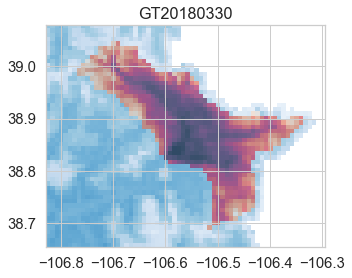

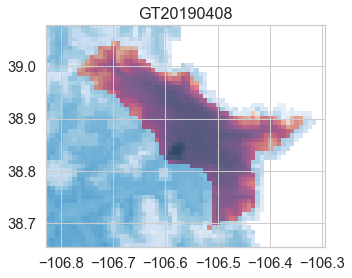

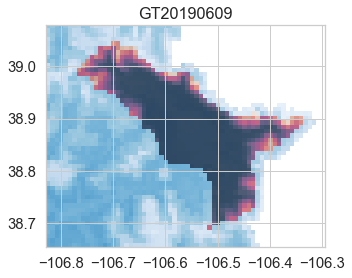

In [ ]:
ASO_files = ['Translated_Rescaled_ReprojectedASO_800M_SWE_USCOBR_20190419.tif', 'Translated_Rescaled_ReprojectedASO_800M_SWE_USCOBR_20190624.tif',
            'Translated_Rescaled_ReprojectedASO_800M_SWE_USCOCB_20160404.tif','Translated_Rescaled_ReprojectedASO_800M_SWE_USCOCM_20190407.tif',
            'Translated_Rescaled_ReprojectedASO_800M_SWE_USCOCM_20190610.tif','Translated_Rescaled_ReprojectedASO_800M_SWE_USCOGE_20180331.tif',
            'Translated_Rescaled_ReprojectedASO_800M_SWE_USCOGE_20190407.tif','Translated_Rescaled_ReprojectedASO_800M_SWE_USCOGE_20180524.tif',
            'Translated_Rescaled_ReprojectedASO_800M_SWE_USCOGE_20190610.tif','Translated_Rescaled_ReprojectedASO_800M_SWE_USCOGT_20180330.tif',
            'Translated_Rescaled_ReprojectedASO_800M_SWE_USCOGT_20190408.tif','Translated_Rescaled_ReprojectedASO_800M_SWE_USCOGT_20190609.tif']
for ASO_file in ASO_files:
    fig, ax = plt.subplots(figsize=(5,5))
    with rio.open(PRISM_file_800M) as src:
        show(src.read(1, masked=True), ax=ax, transform=src.transform, cmap = 'Blues')
    with rio.open(ASO_file) as src:
            show(src.read(1, masked=True), ax=ax, transform=src.transform, alpha=0.6)
            ASO_str_indicator = ASO_file.split('_')[5] + ASO_file.split('_')[6]
            ASO_str_indicator = ASO_str_indicator[4: 14]
            plt.title(ASO_str_indicator)
            plt.colorbar()


# Reprojecting/Rescaling/Translating Topogrophy files

In [ ]:
Files = ['Aspect_800M.tif', 'DEM_800M.tif', 'Slope_800M.tif']

PRISM_file_800M = 'PRISM_TMEAN_20190323.tif'

for file in Files:

    # reproject file
    file_reprojected = 'Reprojected' + file
    desired_crs = 'EPSG:4269'
    reproject_raster(file, file_reprojected, desired_crs)

    #Rescaling the file according to the PRISM_file_800M and saving it in the rescaled_file
    template_file = PRISM_file_800M
    rescaled_file = 'Rescaled_' + file_reprojected
    rescale_src_from_template(PRISM_file_800M, file_reprojected, rescaled_file)


    #we are aligning rescaled_file according to the prism file
    Points_gdf = get_Points_gdf(template_file)
    rescaled_translated_file = 'Translated_' + rescaled_file
    translate_rescaled_src(template_file, file_reprojected, rescaled_file, Points_gdf, rescaled_translated_file)


# Creating CSV files for all snapshots except GE

In [ ]:
def get_ASO_Points_gdf(ASO_file):
    """This function reads in a raster, and obtains Long/Lat values of the center
    of each pixel. It returns a geodataframe."""
    raster = rio.open(ASO_file)
    arr = raster.read(1)
    indices = np.argwhere(~np.isnan(arr))

    coords = raster.xy(indices[:,0], indices[:,1])

    Points_gdf= gpd.GeoDataFrame({'Longitude':coords[0],'Latitude': coords[1]},
                                  geometry=[shapely.geometry.Point(x, y) for x, y in zip(coords[0], coords[1])])

    raster.close()
    return Points_gdf

def get_PRISM_PPT_df(number_of_days, PRISM_folder_path, ASO_date, Points_gdf):
    """This function samples PRISM precipitation values for a number of days leading upto (and including)
    the ASO snapshot. The PRISM values are sampled for the same pixels for which we have ASO
    data.
    """
    PRISM_df = pd.DataFrame()

    for i in np.arange(number_of_days):
        PRISM_date = (ASO_date + datetime.timedelta(days=-int(i))).strftime('%Y%m%d') # we start from the ASO_dat and subtract a day (-int(i))
        year = PRISM_date[:4]
        PRISM_file = f'{PRISM_folder_path}/{year}/PRISM_PPT_{PRISM_date}.tif' #this takes us to the prism_file for the given date at each iteration i

        with rio.open(PRISM_file) as src:
            PRISM_values = pd.Series([val[0] for val in src.sample(zip(Points_gdf['Longitude'], Points_gdf['Latitude']))]) #for every pixel what is the value of precipitation
            PRISM_df.insert(int(i), str(i), pd.Series(PRISM_values)) #inserts it in dataframe

    return PRISM_df


def get_PRISM_TAVG_df(number_of_days, PRISM_folder_path, ASO_date, Points_gdf):
    """This function samples PRISM mean temperature values for a number of days leading upto (and including)
    the ASO snapshot. The PRISM values are sampled for the same pixels for which we have ASO
    data."""
    PRISM_df = pd.DataFrame()

    for i in np.arange(number_of_days):
        PRISM_date = (ASO_date + datetime.timedelta(days=-int(i))).strftime('%Y%m%d')
        year = PRISM_date[:4]
        PRISM_file = f'{PRISM_folder_path}/{year}/PRISM_TMEAN_{PRISM_date}.tif'

        with rio.open(PRISM_file) as src:
            PRISM_values = pd.Series([val[0] for val in src.sample(zip(Points_gdf['Longitude'], Points_gdf['Latitude']))])
            PRISM_df.insert(int(i), str(i), pd.Series(PRISM_values))

    return PRISM_df

In [ ]:
def ASO_to_CSV(ASO_files, truncate_file):

'''  This function taken in raster .tif files and creates csv files.  the CSV files contain 8 columns: longitude, latitue,
slope, aspect, DEM, Sum PDD, Accumulated snow, accumulated precipitation, average temperature, and SWE. It also takes in an optional truncate file
which defines the spatial extent (longitude and latitude) of the CSV file.  '''

    for ASO_file in ASO_files:

        #1. PRISM_FILE PATHS
        PRISM_PPT_folder_path = '/Users/lamaelhalabi/Documents/research Berekely /Lamas processing code/Colorado Maps and generated data/ASO snapshots/PRISM_PPT'
        PRISM_TAVG_folder_path = '/Users/lamaelhalabi/Documents/research Berekely /Lamas processing code/Colorado Maps and generated data/ASO snapshots/PRISM_TMEAN'

        #2.  ASO DATE : From ASO_file string
        ASO_date_str = ASO_file.split('_')[6]
        ASO_date_str = ASO_date_str[: 8]
        ASO_str_indicator = ASO_file.split('_')[5] + ASO_file.split('_')[6]
        ASO_str_indicator = ASO_str_indicator[4: 14]
        ASO_date = datetime.datetime.strptime(ASO_date_str,"%Y%m%d")
        #3. GET Lat and Long
        if truncate_file == 'none':
            Points_gdf = get_ASO_Points_gdf(ASO_file)
        else:
            Points_gdf = get_ASO_Points_gdf(truncate_file)


        #4 : Start date and PRISM_PPT_df and PRISM_TAVG_df for SNOW, ACCUMULATED PRECIPITATION, AVERGAE TEMPERATURE
        start_date_SWA = datetime.datetime(ASO_date.year-1, 10, 1)
        number_of_days_SWA = (ASO_date - start_date_SWA).days + 1

        PRISM_PPT_df = get_PRISM_PPT_df(number_of_days_SWA, PRISM_PPT_folder_path, ASO_date, Points_gdf)
        PRISM_TAVG_df = get_PRISM_TAVG_df(number_of_days_SWA, PRISM_TAVG_folder_path, ASO_date, Points_gdf)

        #5. Get Accumulated PRECIPITATION AND AVERGAE TEMPERATURE
        Accumulated_Prec = np.sum(PRISM_PPT_df,  axis=1)
        Average_Temp = np.mean(PRISM_TAVG_df,  axis=1)

        #6. GET PRISM_SNOW Dataframe
        PRISM_snow_df = PRISM_PPT_df.copy(deep=True)
        PRISM_snow_df.where(PRISM_TAVG_df <= 0.0, other=0.0, inplace=True)

        #7.Get Accumulated snow
        Accumulated_snow = np.sum(PRISM_snow_df.iloc[:,:number_of_days_SWA], axis=1)



        #8: Start date for PDD and PRISM_TAVG.df
        start_date_PDD = datetime.datetime(ASO_date.year, 3, 15) # Start date = Macrh 15
        number_of_days_PDD = (ASO_date - start_date_PDD).days + 1
        PRISM_TAVG_df = get_PRISM_TAVG_df(number_of_days_PDD, PRISM_TAVG_folder_path, ASO_date, Points_gdf)

        #9. Get PRISM_PDD
        Prism_PDD_df = PRISM_TAVG_df.iloc[:,:number_of_days_PDD].where(PRISM_TAVG_df.iloc[:,:number_of_days_PDD] > 0.0, other=0.0)

        #10. Get SUm PDD
        SUM_PDD = np.sum(Prism_PDD_df.iloc[:,:number_of_days_PDD], axis=1)


        #11. ASO and TOPOGRAPHY FILE PATHs: ASO, SLOPE, ASPECT, and DEM
        Topography_file_path_Slope = '/Users/lamaelhalabi/Documents/research Berekely /Lamas processing code/Colorado Maps and generated data/ASO snapshots/Translated_Rescaled_ReprojectedSlope_800M.tif'
        Topography_file_path_Aspect = '/Users/lamaelhalabi/Documents/research Berekely /Lamas processing code/Colorado Maps and generated data/ASO snapshots/Translated_Rescaled_ReprojectedAspect_800M.tif'
        Topography_file_path_DEM = '/Users/lamaelhalabi/Documents/research Berekely /Lamas processing code/Colorado Maps and generated data/ASO snapshots/Translated_Rescaled_ReprojectedDEM_800M.tif'
        ASO_file_path = '/Users/lamaelhalabi/Documents/research Berekely /Lamas processing code/Colorado Maps and generated data/ASO snapshots/' + ASO_file

        #10. Create Topography values and ASO value
        with rio.open(Topography_file_path_Slope) as src:
            Topography_values_Slope = pd.Series([val[0] for val in src.sample(zip(Points_gdf['Longitude'], Points_gdf['Latitude']))])

        with rio.open(Topography_file_path_Aspect) as src:
            Topography_values_Aspect = pd.Series([val[0] for val in src.sample(zip(Points_gdf['Longitude'], Points_gdf['Latitude']))])

        with rio.open(Topography_file_path_DEM) as src:
            Topography_values_DEM = pd.Series([val[0] for val in src.sample(zip(Points_gdf['Longitude'], Points_gdf['Latitude']))])

        with rio.open(ASO_file_path) as src:
            ASO_values = pd.Series([val[0] for val in src.sample(zip(Points_gdf['Longitude'], Points_gdf['Latitude']))])

        #11. create CSV file
        Data_set = pd.DataFrame({'Longitude': Points_gdf['Longitude'], 'Latitude': Points_gdf['Latitude'], 'Slope': Topography_values_Slope, 'Aspect': Topography_values_Aspect, 'DEM': Topography_values_DEM, 'Sum PDD': SUM_PDD, 'Accumulated Snow': Accumulated_snow, 'Accumulate Precipitation': Accumulated_Prec, 'Average Temperature': Average_Temp, 'SWE': ASO_values})
        Data_set.to_csv(ASO_str_indicator + '_Data_set_SWE.csv', index=True)
        Data_set = pd.read_csv(ASO_str_indicator + '_Data_set_SWE.csv', index_col=0)




In [ ]:
ASO_files = ['Translated_Rescaled_ReprojectedASO_800M_SWE_USCOBR_20190419.tif', 'Translated_Rescaled_ReprojectedASO_800M_SWE_USCOBR_20190624.tif',
            'Translated_Rescaled_ReprojectedASO_800M_SWE_USCOCB_20160404.tif','Translated_Rescaled_ReprojectedASO_800M_SWE_USCOCM_20190407.tif',
            'Translated_Rescaled_ReprojectedASO_800M_SWE_USCOCM_20190610.tif','Translated_Rescaled_ReprojectedASO_800M_SWE_USCOGT_20180330.tif',
            'Translated_Rescaled_ReprojectedASO_800M_SWE_USCOGT_20190408.tif','Translated_Rescaled_ReprojectedASO_800M_SWE_USCOGT_20190609.tif']

ASO_to_CSV(ASO_files, 'none')

# Data processing on GE files and generating GE CSV files

# Masking points for which SWE < 0


In [ ]:
def get_Points_gdf_GE(src_file):
    """This function reads in a raster, and obtains Long/Lat values of the center
    of each pixel. It returns a geodataframe."""
    raster = rio.open(src_file)
    arr = raster.read(1)
    indices = np.argwhere(arr > 0) # I need the points for which 0 < SWE
    coords = raster.xy(indices[:,0], indices[:,1])

    Points_gdf= gpd.GeoDataFrame({'Longitude':coords[0],'Latitude': coords[1]},
                                  geometry=[shapely.geometry.Point(x, y) for x, y in zip(coords[0], coords[1])])
    return Points_gdf

In [ ]:
ASO_files = ['Translated_Rescaled_ReprojectedASO_800M_SWE_USCOGE_20180331.tif','Translated_Rescaled_ReprojectedASO_800M_SWE_USCOGE_20190407.tif',
                'Translated_Rescaled_ReprojectedASO_800M_SWE_USCOGE_20180524.tif','Translated_Rescaled_ReprojectedASO_800M_SWE_USCOGE_20190610.tif' ]
i = 0

for ASO_file in ASO_files:
    if i == 0:
        points_gdf_0 = get_Points_gdf_GE(ASO_file)
    if i == 1:
        points_gdf_1 = get_Points_gdf_GE(ASO_file)
    if i == 2:
        points_gdf_2 = get_Points_gdf_GE(ASO_file)
    if i == 3:
        points_gdf_3 = get_Points_gdf_GE(ASO_file)
    i += 1


<AxesSubplot:>

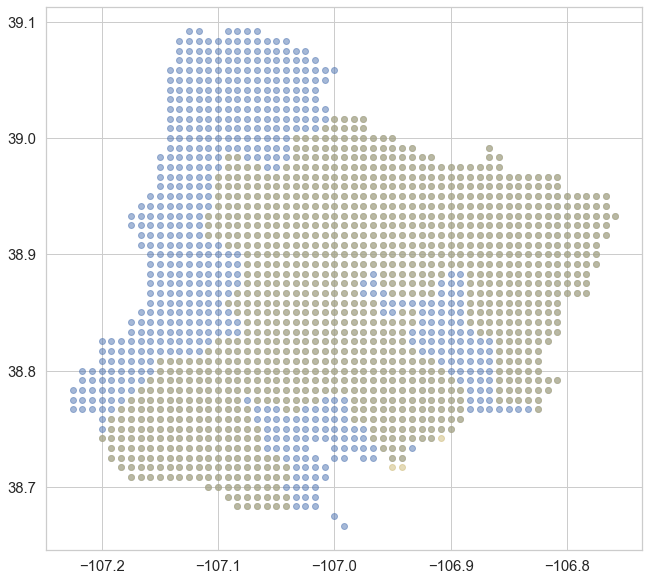

In [ ]:
fig, ax = plt.subplots(figsize=(12,10))
points_gdf_0.plot(ax=ax, color='b', alpha=0.5)
points_gdf_3.plot(ax=ax, color='y', alpha=0.5)

<AxesSubplot:>

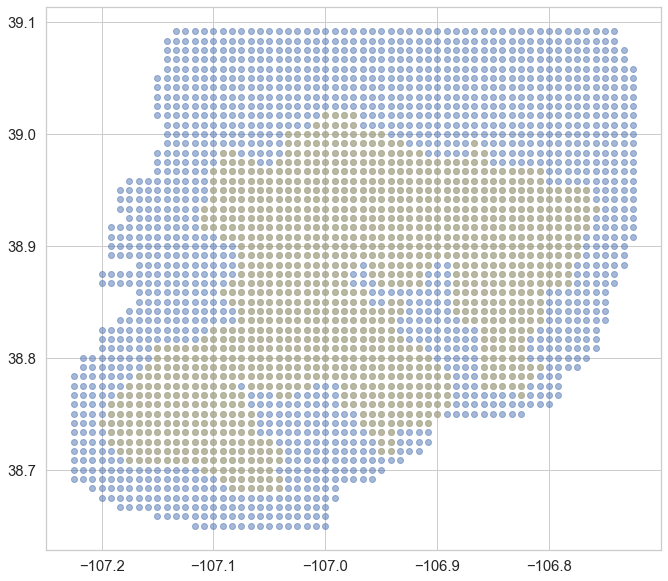

In [ ]:
fig, ax = plt.subplots(figsize=(12,10))
points_gdf_1.plot(ax=ax, color='b', alpha=0.5)
points_gdf_3.plot(ax=ax, color='y', alpha=0.5)

<AxesSubplot:>

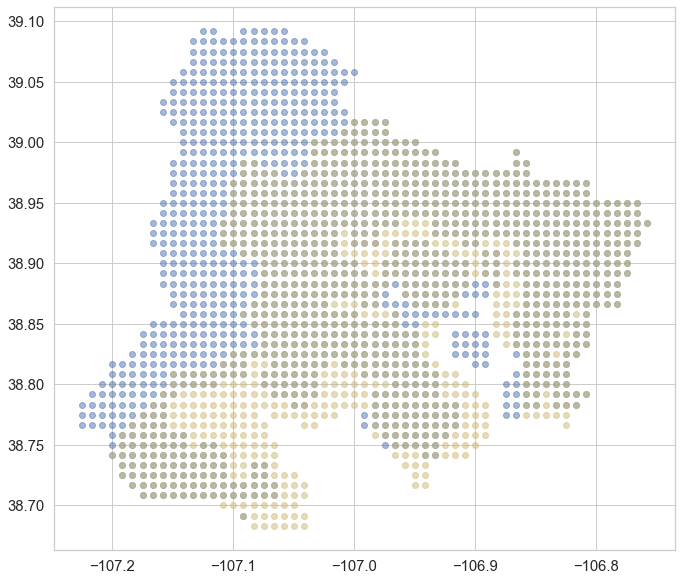

In [ ]:
fig, ax = plt.subplots(figsize=(12,10))
points_gdf_2.plot(ax=ax, color='b', alpha=0.5)
points_gdf_3.plot(ax=ax, color='y', alpha=0.5)

# GE points for 0 < SWE < 1

In [ ]:
def get_Points_gdf_GE(src_file):
    """This function reads in a raster, and obtains Long/Lat values of the center
    of each pixel. It returns a geodataframe."""
    raster = rio.open(src_file)
    arr = raster.read(1)
    indices1 = np.argwhere(arr >0) # I need the points for which 0< SWE < 1
    indices2 = np.argwhere(arr <1)
    indices = []

    for n in indices1:
        for m in indices2:
            if (n[1] == m[1]) and (n[0] == m[0]):
                indices.append(n)
    indices = numpy.array(indices)


    coords = raster.xy(indices[:,0], indices[:,1])

    Points_gdf= gpd.GeoDataFrame({'Longitude':coords[0],'Latitude': coords[1]},
                                  geometry=[shapely.geometry.Point(x, y) for x, y in zip(coords[0], coords[1])])
    return Points_gdf


In [ ]:
ASO_files = ['Translated_Rescaled_ReprojectedASO_800M_SWE_USCOGE_20180331.tif','Translated_Rescaled_ReprojectedASO_800M_SWE_USCOGE_20190407.tif',
                'Translated_Rescaled_ReprojectedASO_800M_SWE_USCOGE_20180524.tif','Translated_Rescaled_ReprojectedASO_800M_SWE_USCOGE_20190610.tif' ]
i = 0

for ASO_file in ASO_files:
    if i == 0:
        points_gdf_0 = get_Points_gdf_GE(ASO_file)
    if i == 1:
        points_gdf_1 = get_Points_gdf_GE(ASO_file)
    if i == 2:
        points_gdf_2 = get_Points_gdf_GE(ASO_file)
    if i == 3:
        points_gdf_3 = get_Points_gdf_GE(ASO_file)
    i += 1


<AxesSubplot:>

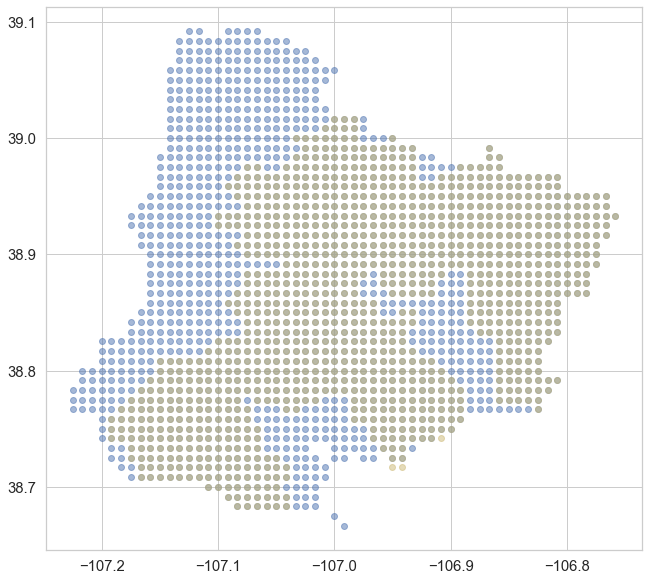

In [ ]:
fig, ax = plt.subplots(figsize=(12,10))
points_gdf_0.plot(ax=ax, color='b', alpha=0.5)
points_gdf_3.plot(ax=ax, color='y', alpha=0.5)

<AxesSubplot:>

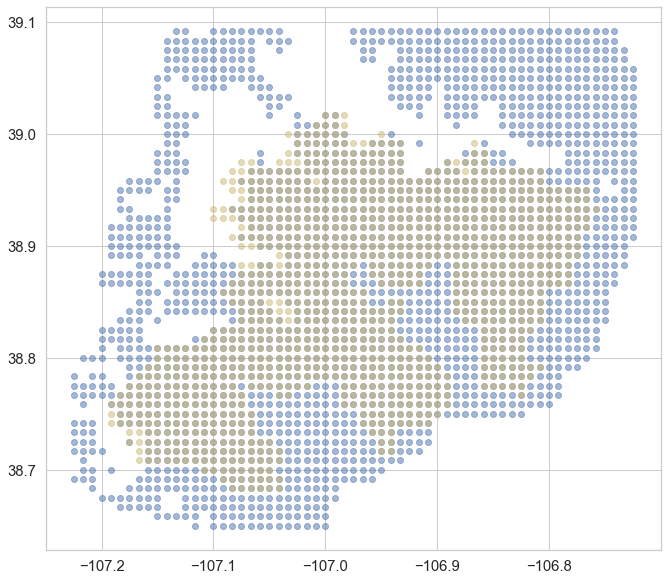

In [ ]:
fig, ax = plt.subplots(figsize=(12,10))
points_gdf_1.plot(ax=ax, color='b', alpha=0.5)
points_gdf_3.plot(ax=ax, color='y', alpha=0.5)

<AxesSubplot:>

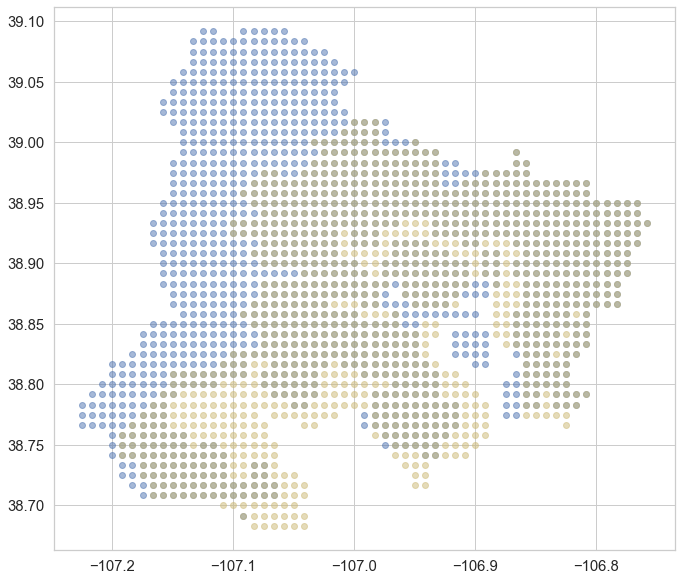

In [ ]:
fig, ax = plt.subplots(figsize=(12,10))
points_gdf_2.plot(ax=ax, color='b', alpha=0.5)
points_gdf_3.plot(ax=ax, color='y', alpha=0.5)

# Creating GE CSV files after deciding the appropriate spatial extent
## we only include the data points for which 0 < SWE < 1
## we truncate according to the spatial extent of GE June 10 2019 except for GE May 24 2018

In [ ]:
ASO_files = ['Translated_Rescaled_ReprojectedASO_800M_SWE_USCOGE_20180331.tif','Translated_Rescaled_ReprojectedASO_800M_SWE_USCOGE_20190407.tif',
                'Translated_Rescaled_ReprojectedASO_800M_SWE_USCOGE_20180524.tif','Translated_Rescaled_ReprojectedASO_800M_SWE_USCOGE_20190610.tif' ]


i = 0
for ASO_file in ASO_files:

    #1. PRISM_FILE PATHS
    PRISM_PPT_folder_path = '/Users/lamaelhalabi/Documents/research Berekely /Lamas processing code/Colorado Maps and generated data/ASO snapshots/PRISM_PPT'
    PRISM_TAVG_folder_path = '/Users/lamaelhalabi/Documents/research Berekely /Lamas processing code/Colorado Maps and generated data/ASO snapshots/PRISM_TMEAN'

    #2.  ASO DATE : From ASO_file string
    ASO_date_str = ASO_file.split('_')[6]
    ASO_date_str = ASO_date_str[: 8]
    ASO_str_indicator = ASO_file.split('_')[5] + ASO_file.split('_')[6]
    ASO_str_indicator = ASO_str_indicator[4: 14]
    ASO_date = datetime.datetime.strptime(ASO_date_str,"%Y%m%d")

    #3. GET Lat and Long
    print(i)
    if i == 0:
        Points_gdf = points_gdf_3
    if i == 1:
        Points_gdf = points_gdf_3
    if i == 2:
        Points_gdf = points_gdf_2
    if i == 3:
        Points_gdf = points_gdf_3

    #4 : Start date and PRISM_PPT_df and PRISM_TAVG_df for SNOW, ACCUMULATED PRECIPITATION, AVERGAE TEMPERATURE
    start_date_SWA = datetime.datetime(ASO_date.year-1, 10, 1) # Start date = October 1
    number_of_days_SWA = (ASO_date - start_date_SWA).days + 1

    PRISM_PPT_df = get_PRISM_PPT_df(number_of_days_SWA, PRISM_PPT_folder_path, ASO_date, Points_gdf)
    PRISM_TAVG_df = get_PRISM_TAVG_df(number_of_days_SWA, PRISM_TAVG_folder_path, ASO_date, Points_gdf)

    #5. Get Accumulated PRECIPITATION AND AVERGAE TEMPERATURE
    Accumulated_Prec = np.sum(PRISM_PPT_df,  axis=1)
    Average_Temp = np.mean(PRISM_TAVG_df,  axis=1)

    #6. GET PRISM_SNOW Dataframe
    PRISM_snow_df = PRISM_PPT_df.copy(deep=True)
    PRISM_snow_df.where(PRISM_TAVG_df <= 0.0, other=0.0, inplace=True)

    #7.Get Accumulated snow
    Accumulated_snow = np.sum(PRISM_snow_df.iloc[:,:number_of_days_SWA], axis=1)

    #8: Start date for PDD and PRISM_TAVG.df
    start_date_PDD = datetime.datetime(ASO_date.year, 3, 15) # Start date = March 15
    number_of_days_PDD = (ASO_date - start_date_PDD).days + 1
    PRISM_TAVG_df = get_PRISM_TAVG_df(number_of_days_PDD, PRISM_TAVG_folder_path, ASO_date, Points_gdf)

    #9. Get PRISM_PDD
    Prism_PDD_df = PRISM_TAVG_df.iloc[:,:number_of_days_PDD].where(PRISM_TAVG_df.iloc[:,:number_of_days_PDD] > 0.0, other=0.0)

    #10. Get SUm PDD
    SUM_PDD = np.sum(Prism_PDD_df.iloc[:,:number_of_days_PDD], axis=1)

    #11. ASO and TOPOGRAPHY FILE PATHs: ASO, SLOPE, ASPECT, and DEM
    Topography_file_path_Slope = '/Users/lamaelhalabi/Documents/research Berekely /Lamas processing code/Colorado Maps and generated data/ASO snapshots/Translated_Rescaled_ReprojectedSlope_800M.tif'
    Topography_file_path_Aspect = '/Users/lamaelhalabi/Documents/research Berekely /Lamas processing code/Colorado Maps and generated data/ASO snapshots/Translated_Rescaled_ReprojectedAspect_800M.tif'
    Topography_file_path_DEM = '/Users/lamaelhalabi/Documents/research Berekely /Lamas processing code/Colorado Maps and generated data/ASO snapshots/Translated_Rescaled_ReprojectedDEM_800M.tif'
    ASO_file_path = '/Users/lamaelhalabi/Documents/research Berekely /Lamas processing code/Colorado Maps and generated data/ASO snapshots/' + ASO_file

    #10. Create Topography values and ASO value
    with rio.open(Topography_file_path_Slope) as src:
        Topography_values_Slope = pd.Series([val[0] for val in src.sample(zip(Points_gdf['Longitude'], Points_gdf['Latitude']))])

    with rio.open(Topography_file_path_Aspect) as src:
        Topography_values_Aspect = pd.Series([val[0] for val in src.sample(zip(Points_gdf['Longitude'], Points_gdf['Latitude']))])

    with rio.open(Topography_file_path_DEM) as src:
        Topography_values_DEM = pd.Series([val[0] for val in src.sample(zip(Points_gdf['Longitude'], Points_gdf['Latitude']))])

    with rio.open(ASO_file_path) as src:
        ASO_values = pd.Series([val[0] for val in src.sample(zip(Points_gdf['Longitude'], Points_gdf['Latitude']))])

    #11. create CSV file
    Data_set = pd.DataFrame({'Longitude': Points_gdf['Longitude'], 'Latitude': Points_gdf['Latitude'], 'Slope': Topography_values_Slope, 'Aspect': Topography_values_Aspect, 'DEM': Topography_values_DEM, 'Sum PDD': SUM_PDD, 'Accumulated Snow': Accumulated_snow, 'Accumulate Precipitation': Accumulated_Prec, 'Average Temperature': Average_Temp, 'SWE': ASO_values})
    Data_set.to_csv(ASO_str_indicator + '_Data_set_SWE.csv', index=True)
    Data_set = pd.read_csv(ASO_str_indicator + '_Data_set_SWE.csv', index_col=0)
    i += 1






0
1
2
3


# Generating Backward Accumulate and sum pdd figures

BR: 19 Apr 2019


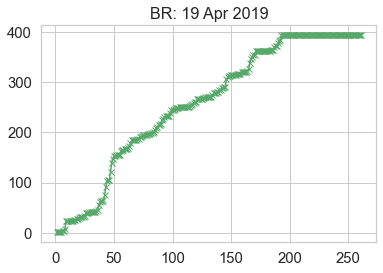

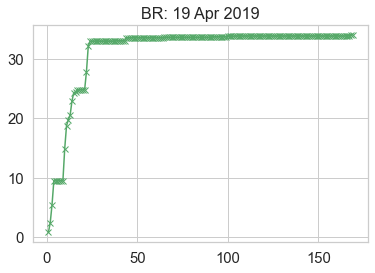

BR: 24 Jun 2019


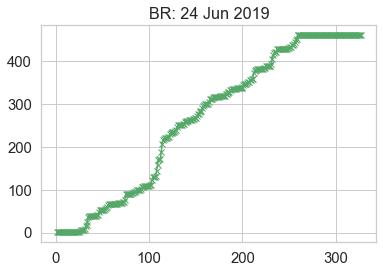

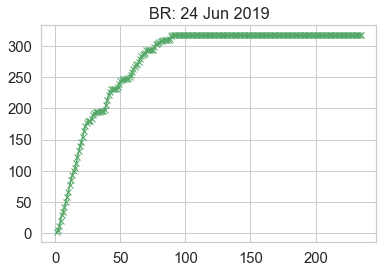

CB: 04 Apr 2016


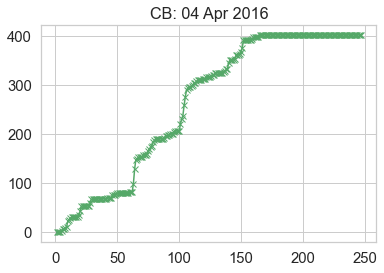

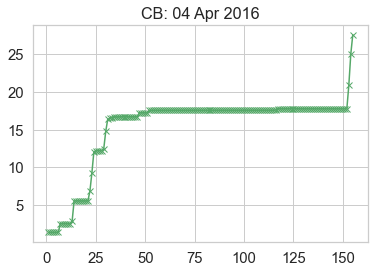

CM: 07 Apr 2019


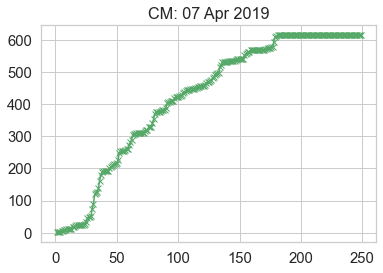

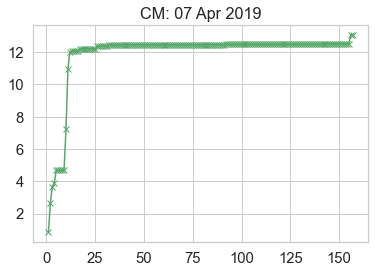

CM: 10 Jun 2019


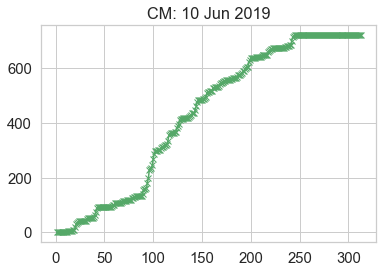

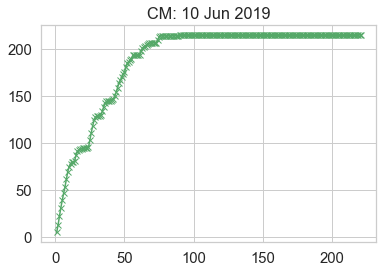

GE: 31 Mar 2018


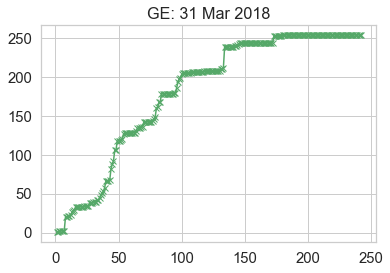

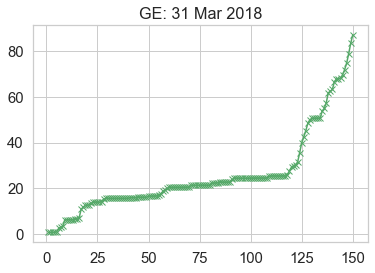

GE: 07 Apr 2019


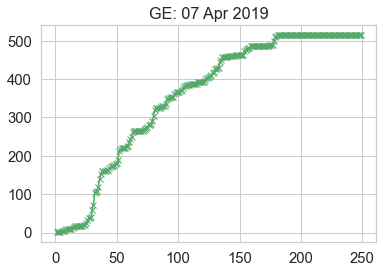

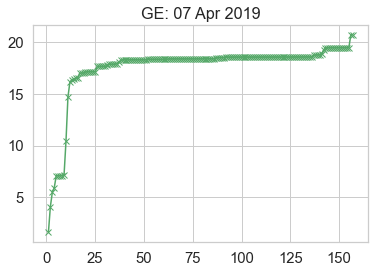

GE: 24 May 2018


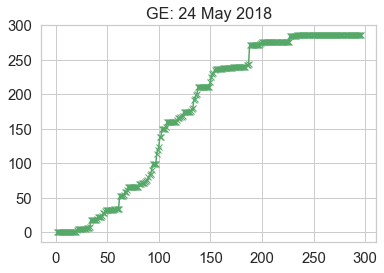

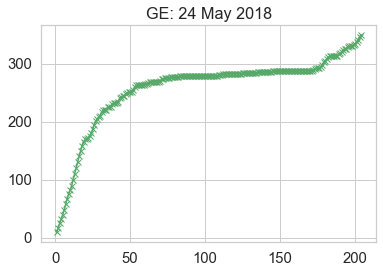

GE: 10 Jun 2019


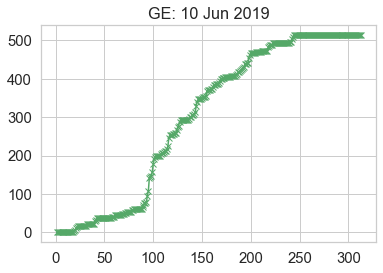

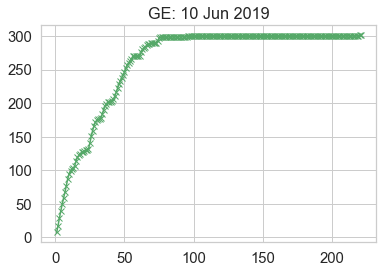

GT: 30 Mar 2018


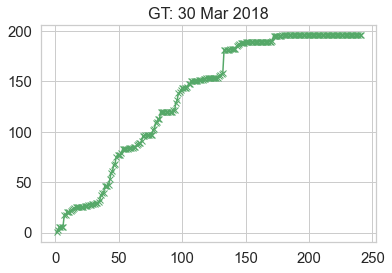

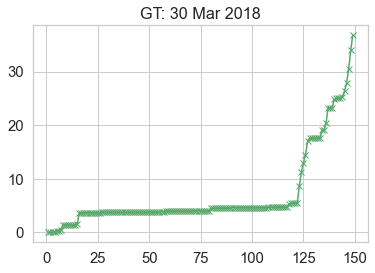

GT: 08 Apr 2019


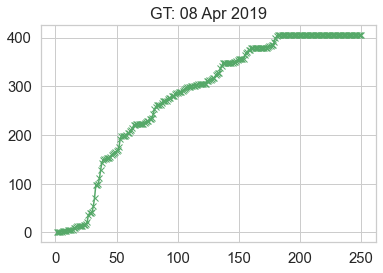

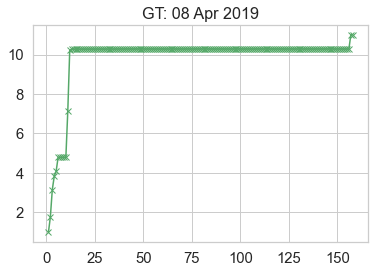

GT: 09 Jun 2019


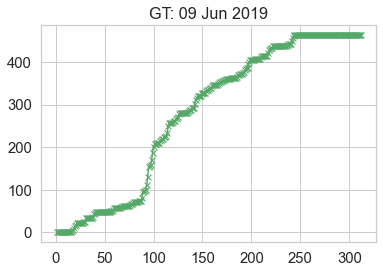

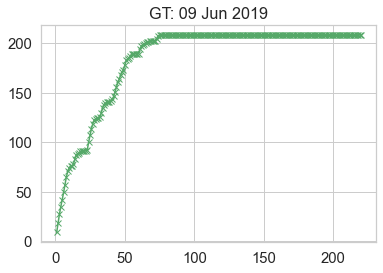

In [ ]:
ASO_files = ['Translated_Rescaled_ReprojectedASO_800M_SWE_USCOBR_20190419.tif', 'Translated_Rescaled_ReprojectedASO_800M_SWE_USCOBR_20190624.tif',
            'Translated_Rescaled_ReprojectedASO_800M_SWE_USCOCB_20160404.tif','Translated_Rescaled_ReprojectedASO_800M_SWE_USCOCM_20190407.tif',
            'Translated_Rescaled_ReprojectedASO_800M_SWE_USCOCM_20190610.tif','Translated_Rescaled_ReprojectedASO_800M_SWE_USCOGE_20180331.tif',
            'Translated_Rescaled_ReprojectedASO_800M_SWE_USCOGE_20190407.tif','Translated_Rescaled_ReprojectedASO_800M_SWE_USCOGE_20180524.tif',
            'Translated_Rescaled_ReprojectedASO_800M_SWE_USCOGE_20190610.tif','Translated_Rescaled_ReprojectedASO_800M_SWE_USCOGT_20180330.tif',
            'Translated_Rescaled_ReprojectedASO_800M_SWE_USCOGT_20190408.tif','Translated_Rescaled_ReprojectedASO_800M_SWE_USCOGT_20190609.tif']

for ASO_file in ASO_files:
#1. PRISM_FILE PATHS
    PRISM_PPT_folder_path = '/Users/lamaelhalabi/Documents/research Berekely /Lamas processing code/Colorado Maps and generated data/ASO snapshots/PRISM_PPT'
    PRISM_TAVG_folder_path = '/Users/lamaelhalabi/Documents/research Berekely /Lamas processing code/Colorado Maps and generated data/ASO snapshots/PRISM_TMEAN'

    #2.  ASO DATE : From ASO_file string and ASO indicator
    ASO_date_str = ASO_file.split('_')[6]
    ASO_date_str = ASO_date_str[: 8]
    ASO_str_indicator = ASO_file.split('_')[5] + ASO_file.split('_')[6]
    ASO_str_indicator = ASO_str_indicator[4: 14]
    ASO_date = datetime.datetime.strptime(ASO_date_str,"%Y%m%d")
    basin = ASO_str_indicator[0:2]
    title = f'{basin}: {ASO_date .strftime("%d %b %Y")}'
    print(title)

    ASO_date = datetime.datetime.strptime(ASO_date_str,"%Y%m%d")

    #3. GET Lat and Long for ASO File
    Points_gdf = get_ASO_Points_gdf(ASO_file)

    #4.0 Accumulated snow
    start_date_snow = datetime.datetime(ASO_date.year-1, 8, 1) # Start date = August 1 of the previous year
    number_of_days_snow = (ASO_date - start_date_snow).days + 1

    #4.1 Prism get PTT and TMEAN
    PRISM_PPT_df = get_PRISM_PPT_df(number_of_days_snow, PRISM_PPT_folder_path, ASO_date, Points_gdf)
    PRISM_TAVG_df = get_PRISM_TAVG_df(number_of_days_snow, PRISM_TAVG_folder_path, ASO_date, Points_gdf)

    #4.2 GET PRISM_SNOW Dataframe
    PRISM_snow_df = PRISM_PPT_df.copy(deep=True)
    PRISM_snow_df.where(PRISM_TAVG_df <= 0.0, other=0.0, inplace=True)

    #4.3 Get Mean Accumulated snow
    mean_accum_snow = [np.mean(np.sum(PRISM_snow_df.iloc[:,:n_days], axis=1)) for n_days in range(1, number_of_days_snow)]

    #4.4 Plot Accumulated Snow
    plt.plot(range(1, number_of_days_snow), mean_accum_snow, '-xC2')
    plt.title(title)
    plt.savefig(ASO_str_indicator + 'Snow.png', bbox_inches = 'tight')
    plt.show()

    #5.0 Sum PDD
    start_date_PDD = datetime.datetime(ASO_date.year-1, 11, 1) # Start date = November 1 of the previous year
    number_of_days_PDD= (ASO_date - start_date_PDD).days + 1

    #5.1 Prism get PTT and TAVG
    PRISM_PPT_df = get_PRISM_PPT_df(number_of_days_PDD, PRISM_PPT_folder_path, ASO_date, Points_gdf)
    PRISM_TAVG_df = get_PRISM_TAVG_df(number_of_days_PDD, PRISM_TAVG_folder_path, ASO_date, Points_gdf)

    #5.2 Get PRISM_PDD Dataframe
    Prism_PDD_df = PRISM_TAVG_df.iloc[:,:number_of_days_PDD].where(PRISM_TAVG_df.iloc[:,:number_of_days_PDD] > 0.0, other=0.0)

    #5.3 Get SUM PDD
    SUM_PDD = [np.mean(np.sum(Prism_PDD_df.iloc[:,:n_days], axis=1)) for n_days in range(1, number_of_days_PDD)]

    #5.4 Plot SUM PDD
    plt.plot(range(1, number_of_days_PDD), SUM_PDD, '-xC2')
    plt.title(title)
    plt.savefig( ASO_str_indicator + 'PDD.png', bbox_inches = 'tight')
    plt.show()

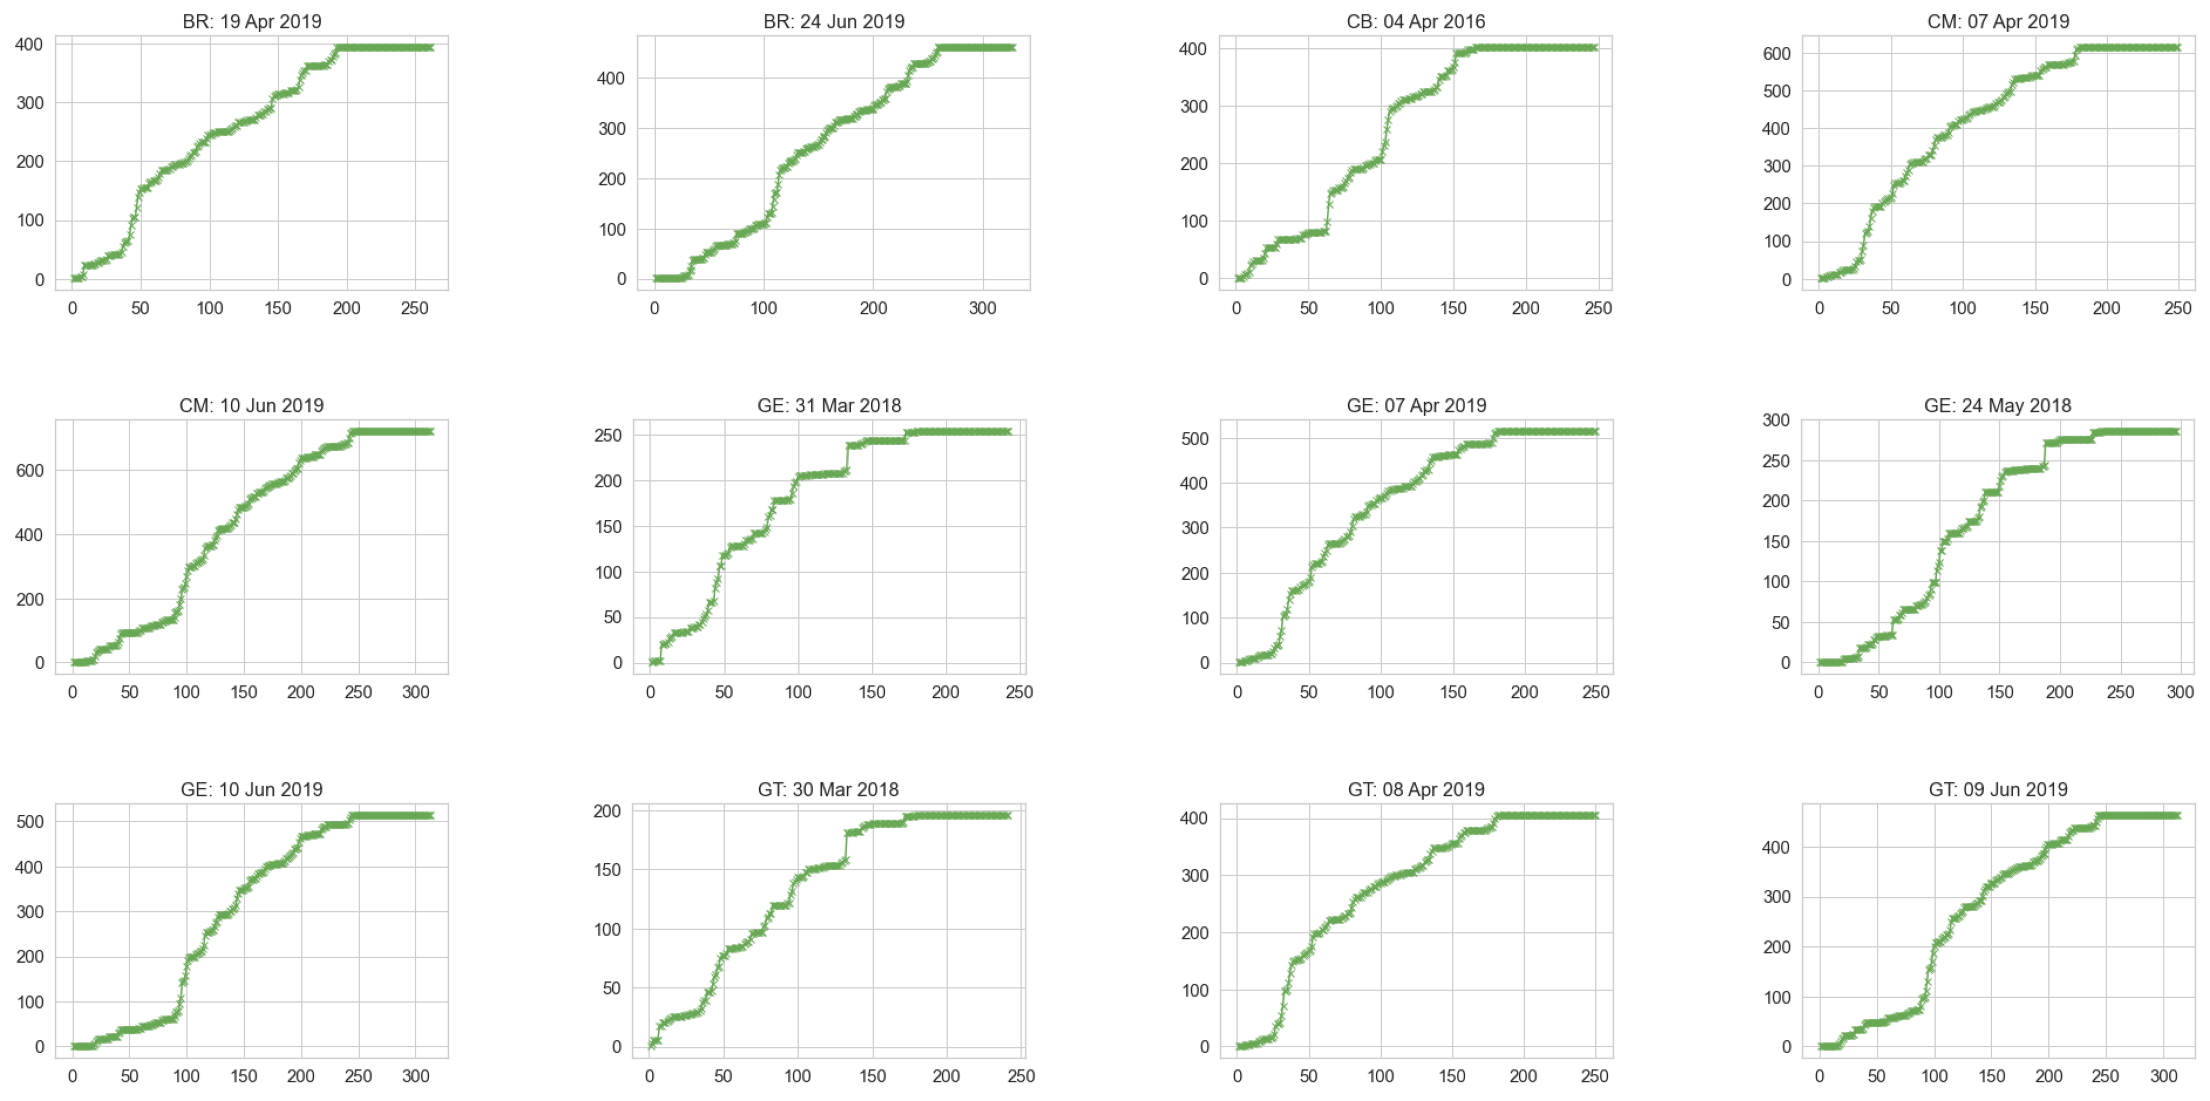

In [ ]:

# code for displaying multiple images in one figure

#import libraries
import cv2
from matplotlib import pyplot as plt

# create figure
fig = plt.figure(figsize=(40, 20))

# setting values to rows and column variables
rows = 3
columns = 4

# reading images
Image1 = cv2.imread('BR20190419Snow.png')
Image2 = cv2.imread('BR20190624Snow.png')
Image3 = cv2.imread('CB20160404Snow.png')
Image4 = cv2.imread('CM20190407Snow.png')
Image5 = cv2.imread('CM20190610Snow.png')

Image6 = cv2.imread('GE20180331Snow.png')
Image7 = cv2.imread('GE20190407Snow.png')
Image8 = cv2.imread('GE20180524Snow.png')
Image9 = cv2.imread('GE20190610Snow.png')
Image10 = cv2.imread('GT20180330Snow.png')
Image11 = cv2.imread('GT20190408Snow.png')
Image12 = cv2.imread('GT20190609Snow.png')
Images = [Image1, Image2, Image3, Image4, Image5, Image6, Image7, Image8, Image9, Image10, Image11, Image12]
index = 1

for image in Images:

    # Adds a subplot at the 1st position
    fig.add_subplot(rows, columns, index)

    # showing image
    plt.imshow(image)
    plt.axis('off')
    index += 1

plt.savefig('AccumulatedSnowfall_COL.png', bbox_inches = 'tight')




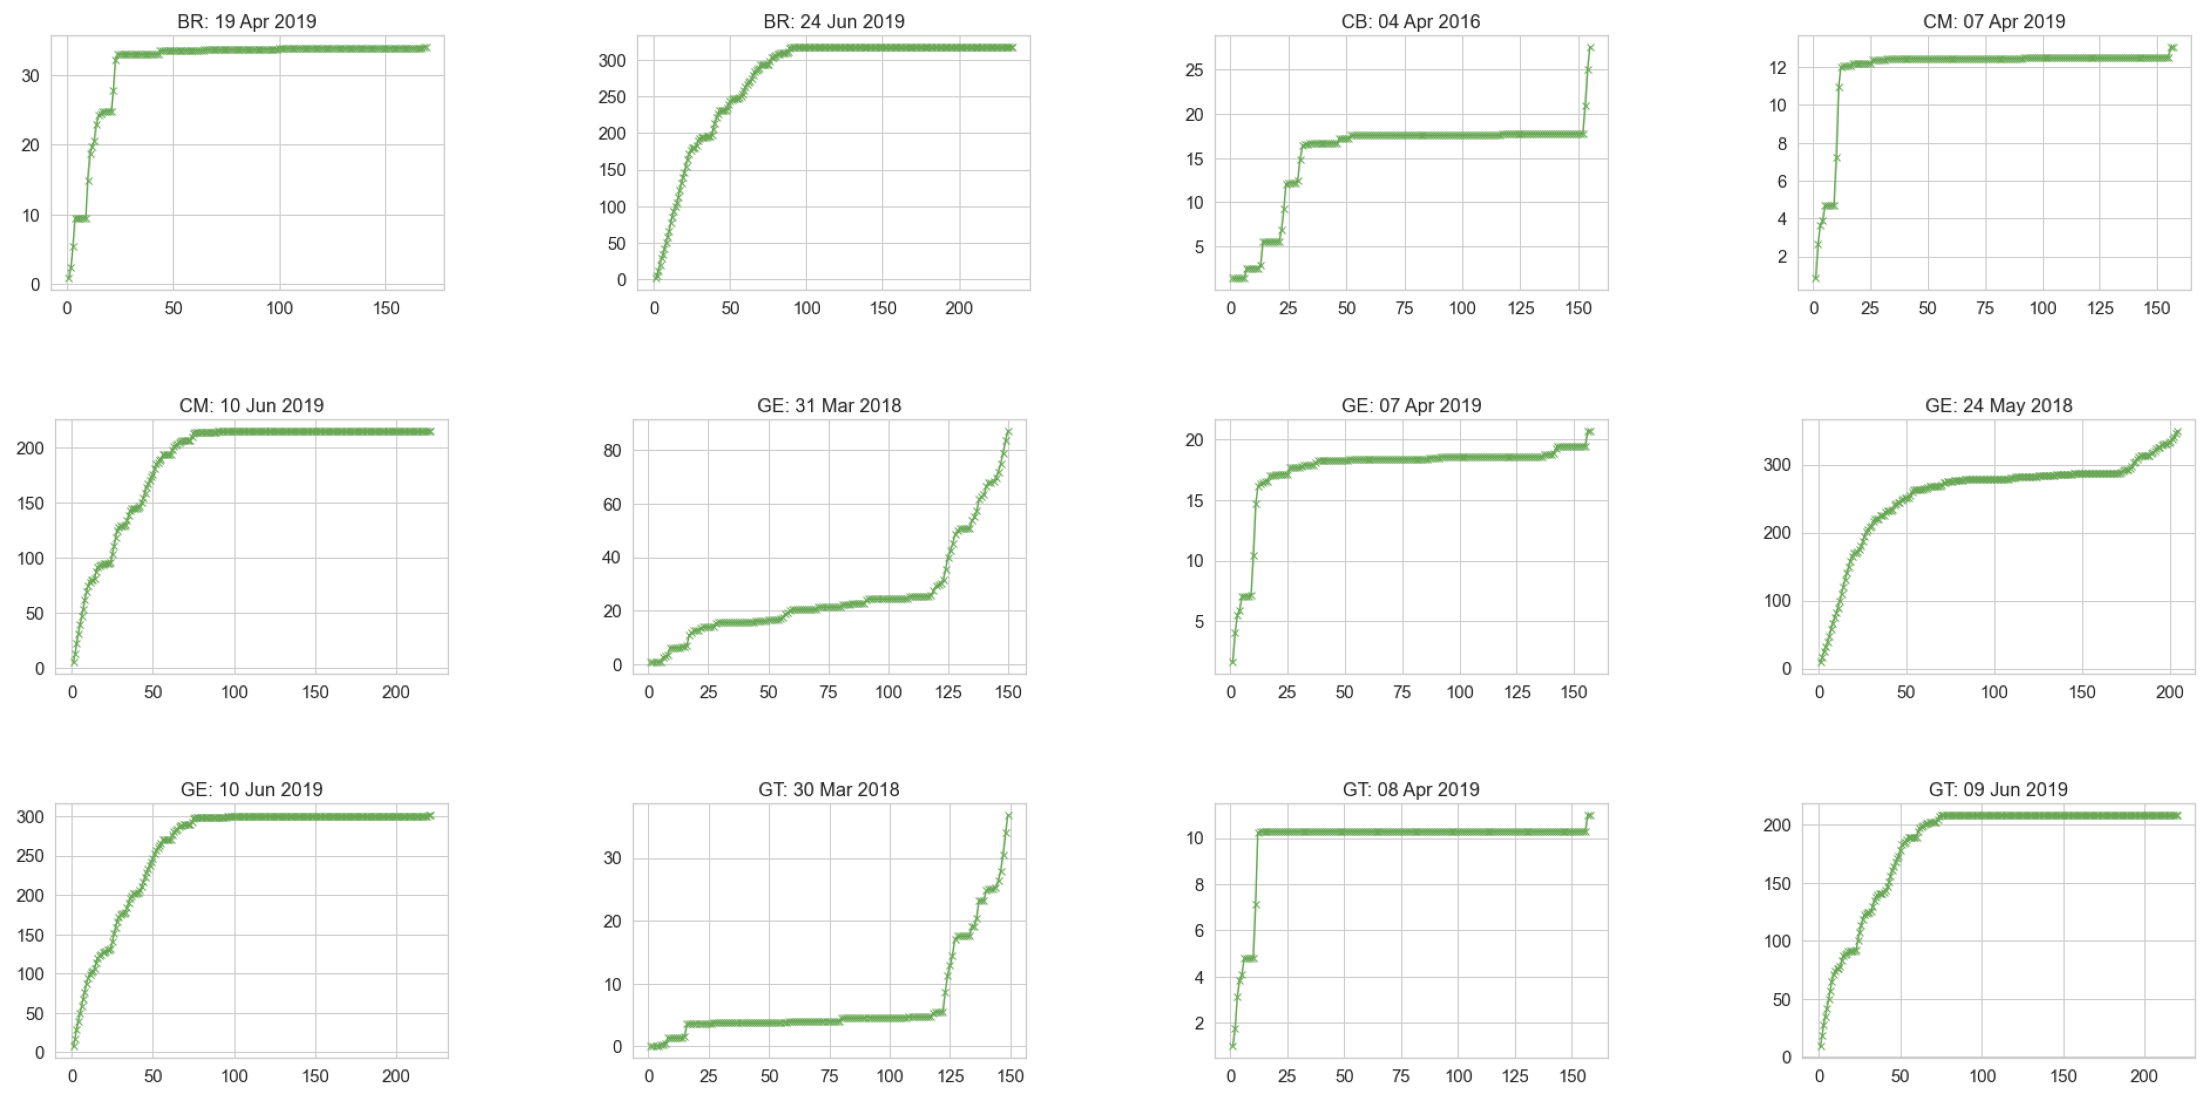

In [ ]:
# code for displaying multiple images in one figure

#import libraries
import cv2
from matplotlib import pyplot as plt

# create figure
fig = plt.figure(figsize=(40, 20))

# setting values to rows and column variables
rows = 3
columns = 4

# reading images
Image1 = cv2.imread('BR20190419PDD.png')
Image2 = cv2.imread('BR20190624PDD.png')
Image3 = cv2.imread('CB20160404PDD.png')
Image4 = cv2.imread('CM20190407PDD.png')
Image5 = cv2.imread('CM20190610PDD.png')

Image6 = cv2.imread('GE20180331PDD.png')
Image7 = cv2.imread('GE20190407PDD.png')
Image8 = cv2.imread('GE20180524PDD.png')
Image9 = cv2.imread('GE20190610PDD.png')
Image10 = cv2.imread('GT20180330PDD.png')
Image11 = cv2.imread('GT20190408PDD.png')
Image12 = cv2.imread('GT20190609PDD.png')
Images = [Image1, Image2, Image3, Image4, Image5, Image6, Image7, Image8, Image9, Image10, Image11, Image12]
index = 1

for image in Images:

    # Adds a subplot at the 1st position
    fig.add_subplot(rows, columns, index)

    # showing image
    plt.imshow(image)
    plt.axis('off')
    index += 1

plt.savefig('SUMPDD_COL.png', bbox_inches = 'tight')



